## **Problem Statement**
We have to perform **Cohort Analysis** and **RFM Segmentation** to understand the value derived from different customer segments.

## **Dataset Description**
This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

### **Variables	Description**
- **InvoiceNo(Nominal):** a six digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
- **StockCode(Nominal):** refer to Product item code, a five digit integral number uniquely assigned to each distinct product
- **Description(Nominal)** Product item name.
- **Quantity**(Numeric): The quantities of each product item per transaction.
- **InvoiceDate(Numeric):** the day and time when each transaction was generated
- **UnitPrice(Numeric):** product price per unit in sterling
- **CustomerID(Nominal):** a six digit integral number uniquely assigned to each customer
- **Country(Nominal):** the name of the country where each customer resides

#### **Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# sns.set_palette('Set2')
import matplotlib.pyplot as plt
%matplotlib inline

# Supress Scientific notation in python
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display all columns of long dataframe
pd.set_option('display.max_columns', None)

import time
import datetime as dt

warnings.filterwarnings("ignore")

#### **Loading & Reading Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import dataset
train= pd.read_excel("/content/drive/MyDrive/Python/Datasets/Online Retail (1).xlsx", parse_dates=['InvoiceDate'])

In [4]:
# Reading the dataset
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [5]:
# Check the shape of dataset
train.shape
print(f'Our dataset contains of Rows,Columns: {train.shape}')

Our dataset contains of Rows,Columns: (541909, 8)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### **Duplicate records**

Let's check for any duplicate record first, as those need to be removed first before any further analysis.

In [7]:
print(f'Duplicate items in train dataset is {train.duplicated().sum()}')

Duplicate items in train dataset is 5268


In [8]:
# Remove duplicate items
train = train[~train.duplicated()]

In [9]:
# Recheck for the Duplicates
print(f'Duplicate items in train dataset is {train.duplicated().sum()}')

Duplicate items in train dataset is 0


**Info:**
* So after removing the duplicate we can see now that there isn't any duplicates items in the dataset.
* So, now we can process to our analysis.

#### **Missing values**

Let's check for any missing values in the dataset

In [10]:
train.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

<Axes: >

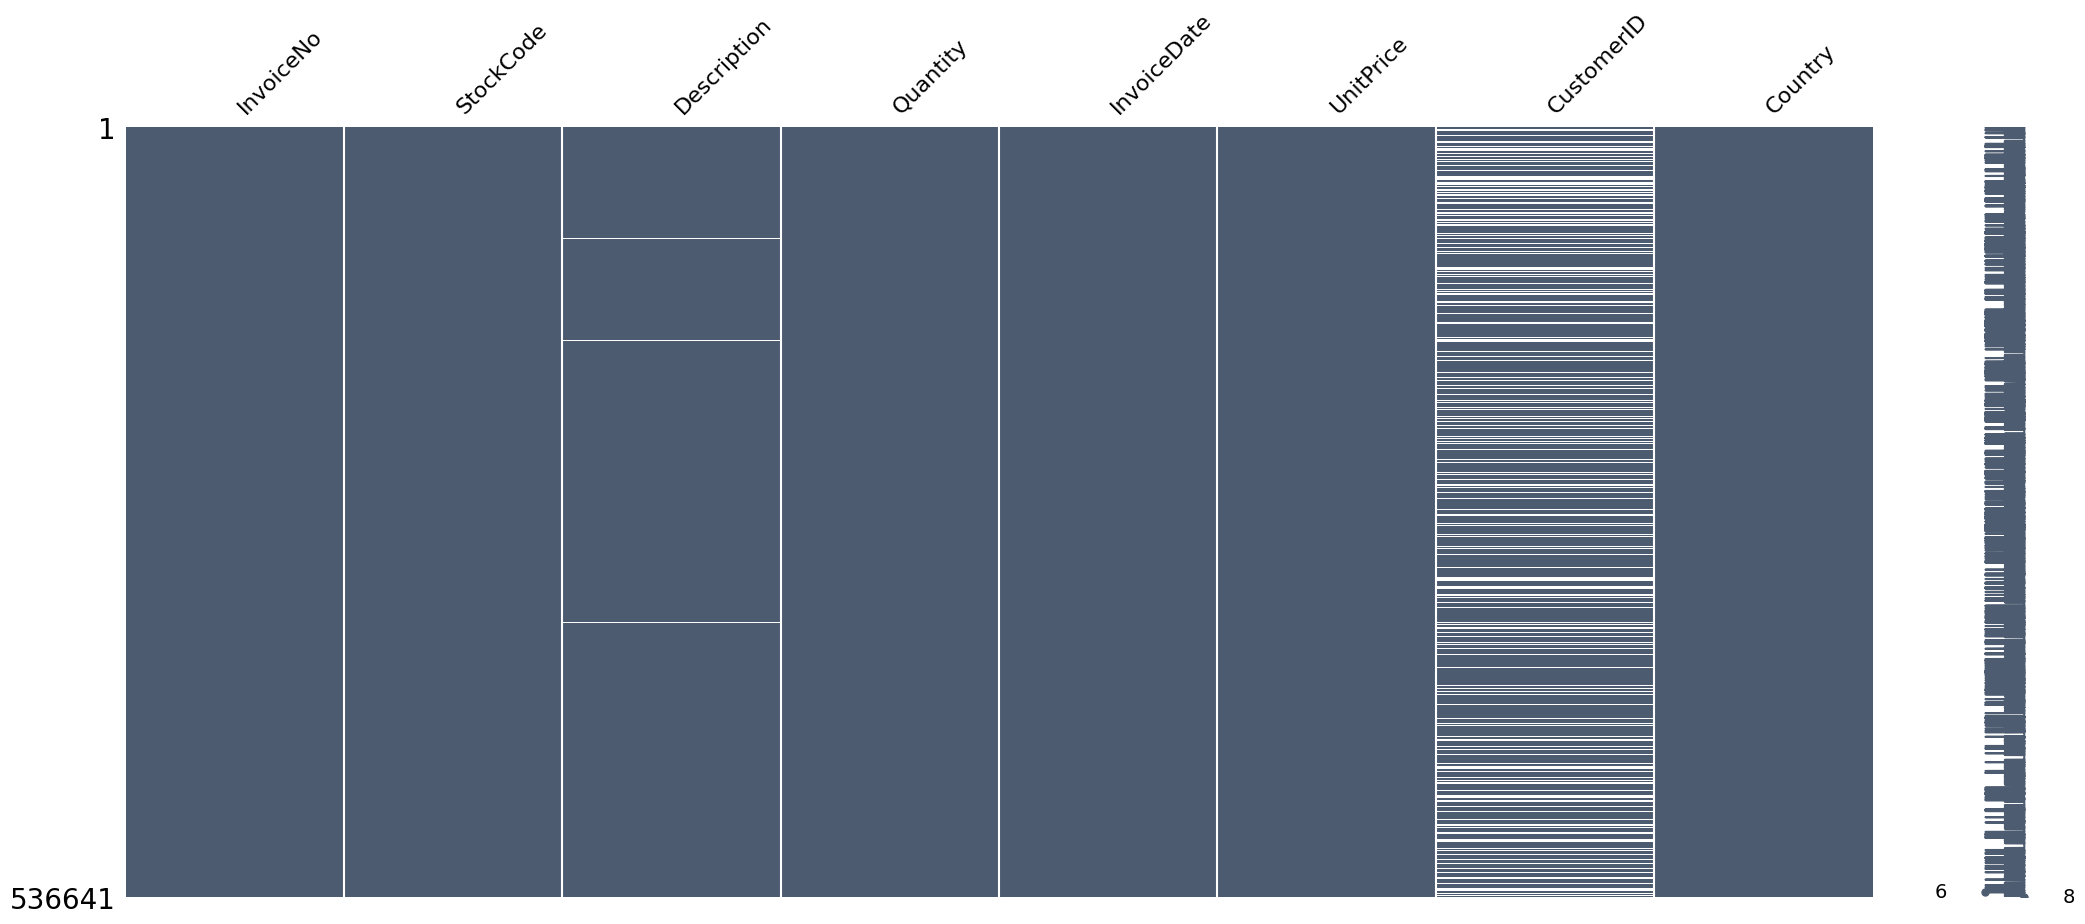

In [11]:
#Missing data as white lines
import missingno as msno
msno.matrix(train,color=(0.3,0.36,0.44))

In [12]:
# Define function to find missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"+"There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [13]:
missing_values_table(train)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CustomerID,135037,25.20
Description,1454,0.30


**Info:**
* So around **25%** of records don't have customer id value, such records are not useful for the RFM analysis.
* But let's check further if there are any common records which have null and non-null customer ID but same invoice number.
* So that we can fill the records with same customer ID and try to decrease the loss.

In [14]:
# Create a list of unique InvoiceNo with null CustomerID records
Invoice_list = train[train.CustomerID.isnull()]['InvoiceNo'].tolist()

In [15]:
# Check for the number of records with these InvoicNo
len(train[train.InvoiceNo.isin(Invoice_list)])

135037

**Info:**
* Here we found that the count of the Invoice with null customerID is equivalent to the number of records with missing CustomerID.
* Therefore we are unable to prevent the loss and have to remove all such records before any further analysis.

In [16]:
# We don't need records with Null customer id for RFM analysis so let's remove those first
rfm_train = train[train.CustomerID.notnull()].copy()

In [17]:
# Convert remaining Customer Ids to int type
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [18]:
# Check the count of missing values after removing Null customer id records
missing_values_table(rfm_train) # Train

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [19]:
rfm_train.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### **Cancelled items**

Let's check those record which shows cancelled items. These records are not needed for Descriptive analysis but are accountable for the RFM analysis. So let's keep them in a different dataframe altogether.

In [20]:
# Check and remove transactions with cancelled items.
desc_df = rfm_train[~rfm_train.InvoiceNo.str.contains('C', na=False)]

In [21]:
# Let's create a feature with total cost of the transactions
desc_df['Total_cost'] = rfm_train.Quantity * rfm_train.UnitPrice

In [22]:
# Lets's check new dataset
desc_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### **EDA**

Now let's do some Exploratory Data Analysis on the processed dataset

In [23]:
# Check the oldest and latest date in the dataset.
print(f'Oldest date is - {desc_df.InvoiceDate.min()}\n')
print(f'Latest date is - {desc_df.InvoiceDate.max()}')

Oldest date is - 2010-12-01 08:26:00

Latest date is - 2011-12-09 12:50:00


**Top 10 countries with highest transactions?**

In [24]:
# Check the top ten countries in the dataset with highest transactions
desc_df.Country.value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: Country, dtype: object

**Info:**
* Almost 90% of records belong to the sales done in UK with some it's and bits in other countries.

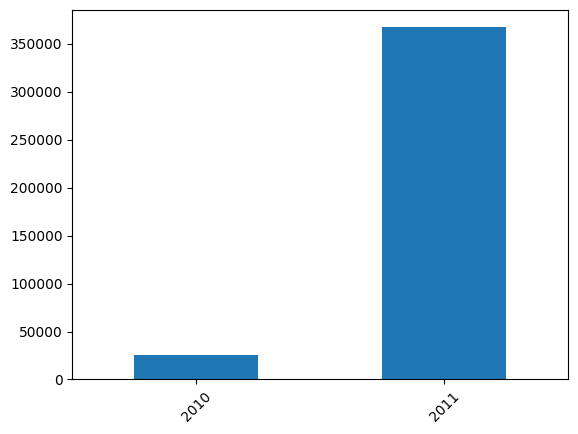

In [25]:
# Count of transactions in different years
desc_df.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', rot=45);

**Info:**
* Since 2010 only includes transactions done in December, therefore it is evident that most of the records belong to 2011.

**Transactions in different months within 2011?**

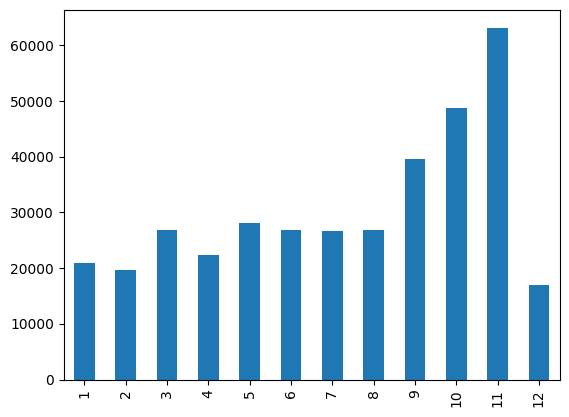

In [26]:
# Count of transactions in different months within 2011 year.
desc_df[desc_df.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar');

**Info:**
* An increasing pattern can be observed month by month wise with a sharp decline in the month of December.
* That is evident because only first 8-9 days of December 2011 month is available in the dataset, i.e. around 70% of the month transactions are not considered.
* Due to this fact, sales figure looks legitimate.

**Top grossing months trends?**

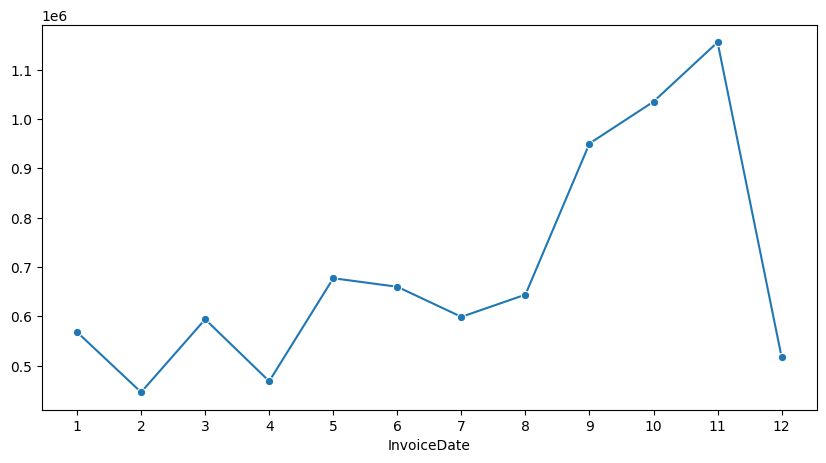

In [27]:
# Let's visualize the top grossing months
monthly_gross = desc_df[desc_df.InvoiceDate.dt.year==2011].groupby(desc_df.InvoiceDate.dt.month).Total_cost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o');
plt.xticks(range(1,13))
plt.show();

**Info:**
* A similar pattern is also observed in total gross each month as per the count of transactions in each month.

**Boxplot for the different metrics distribution**

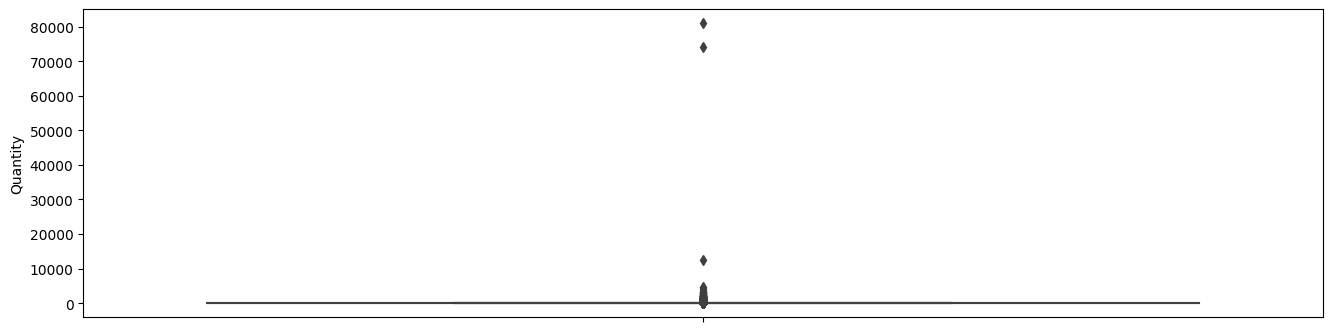

In [28]:
# Boxplot to visualize the Quantity distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='Quantity', data=desc_df, orient='h');

**Info:**
* This shows that Quantity data is highly skewed towards lower quantity values with some outliers.
May be data entry error or might be genuine order

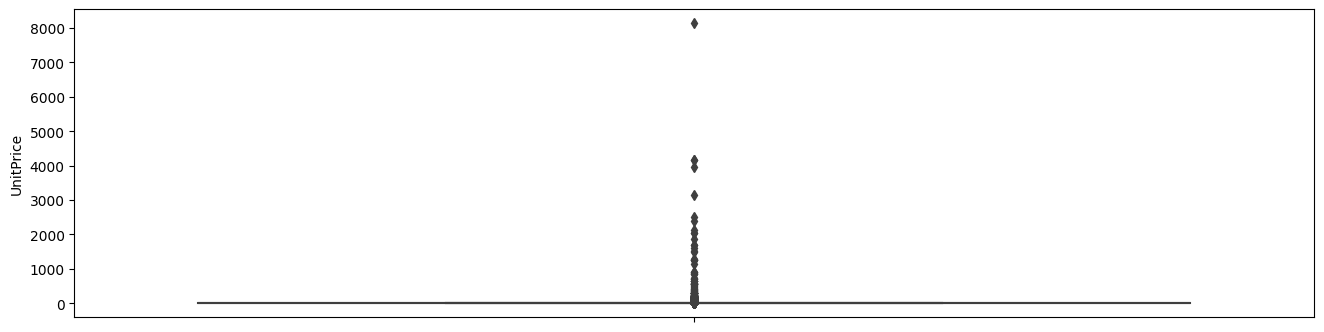

In [29]:
# Let's visualize the Unit price distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice', data=desc_df, orient='h');

**Info:**
* Similarly, Price of unit data shows heavy skewed distribution towards lower values of unit price.

**Top products from the whole range**

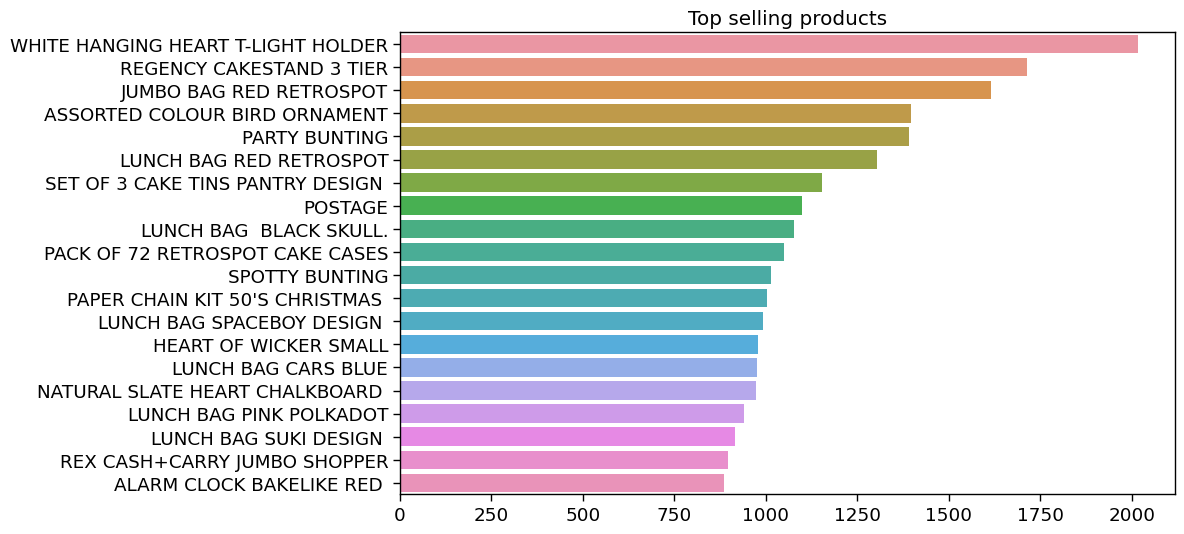

In [30]:
# Let's visualize some top products from the whole range.
top_products = desc_df['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();

## **Cohort Analysis**

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts.

#### **Types of cohorts:**

- **Time Cohorts** are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be `monthly` or `quarterly` even `daily`.
- **Behavior cohorts** are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understanding the needs of the various cohorts can help a company design custom-made services or products for particular segments.
- **Size cohorts** refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.

**For cohort analysis, there are a few labels that we have to create:**

- **Invoice period** - A string representation of the year and month of a single transaction/invoice.
- **Cohort group:**- A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
- **Cohort period/Index**-  A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [31]:
# Create a copy of rfm_train dataframe for cohort analysis
cohort = rfm_train.copy()

**Assign monthly acquisition cohort**

Defining a cohort is the first step to cohort analysis. We will now create monthly cohorts based on the month each customer has made their first transaction.

In [32]:
# Define a function that will parse the date
def get_month(x):
    return dt.datetime(x.year,x.month,1)

# Create InvoiceMonth column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month)

# Group by CustomerID and select the InvoiceMonth value
grouping = cohort.groupby('CustomerID')['InvoiceMonth']

# Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')

**Calculate time offset in months**

Calculating time offset for each transaction allows you to report the metrics for each cohort in a comparable fashion.

First, we will create some variables that capture the integer value of years and months for Invoice and Cohort Date using the get_date_int() function

In [33]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [34]:
# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

In [35]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

In [36]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1


**Calculate retention rate**

Customer retention is a very useful metric to understand how many of all the customers are still active. It gives you the percentage of active customers compared to the total number of customers


In [37]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

In [38]:
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)*100

### **Monthly Retention Cohorts**

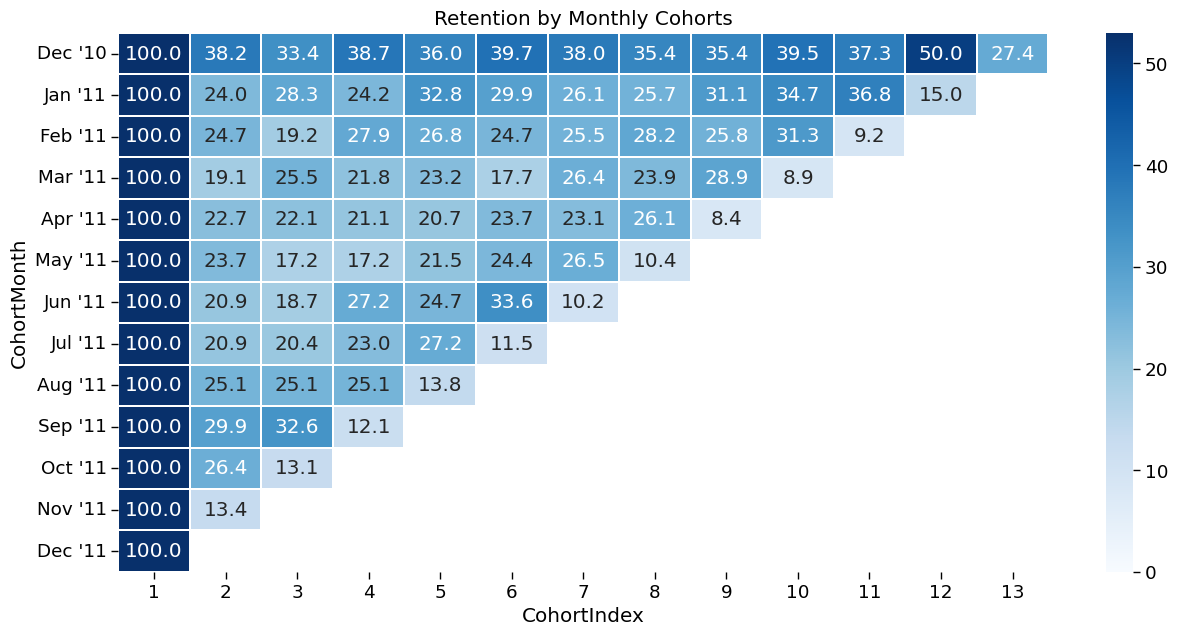

In [39]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

# Initialize inches plot figure
plt.figure(figsize=(15,7))

# Add a title
plt.title('Retention by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=retention,
            annot = True,
            cmap = "Blues",
            vmin = 0.0,
#             vmax = 0.5,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show();

#### **Interpretations**
1. **Initial Engagement:**
   - In general, each cohort starts with a 100% retention rate in the initial month, indicating that all customers who joined in that month continued to use your product.

2. **Fluctuations:**
   - There are fluctuations in retention rates for most cohorts over the months that follow. These fluctuations suggest that customer engagement varied over time.

3. **Peaks and Drops:**
   - Some cohorts experienced peaks in retention rates in certain months, which may indicate specific events, promotions, or factors that led to increased engagement.
   - Conversely, several cohorts experienced significant drops in retention rates in certain months, indicating that a portion of customers did not continue to engage with your product.

4. **Long-Term Trends:**
   - For some cohorts, retention rates gradually decline over time, while for others, there is a mix of increases and decreases.

5. **Considerations:**
   - It's important to analyze what contributed to the higher retention rates in some months and lower retention rates in others. Factors such as seasonality, product changes, marketing efforts, and external events may influence these trends.

6. **Retention Strategies:**
   - To maintain and improve customer retention, consider conducting a deeper analysis of the factors affecting retention for each cohort.
   - Identify what worked well during months with high retention and develop strategies to replicate or sustain that success.
   - For months with low retention, investigate the causes and implement strategies to enhance customer engagement and loyalty.

Overall, these retention rates provide valuable insights into customer behavior over time. By analyzing the factors driving these trends, we can make data-driven decisions to enhance customer retention and engagement for future cohorts.


**Calculate average price per cohort**

Now we will calculate the average price metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [40]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date

### **Monthly Average Spend Cohorts**

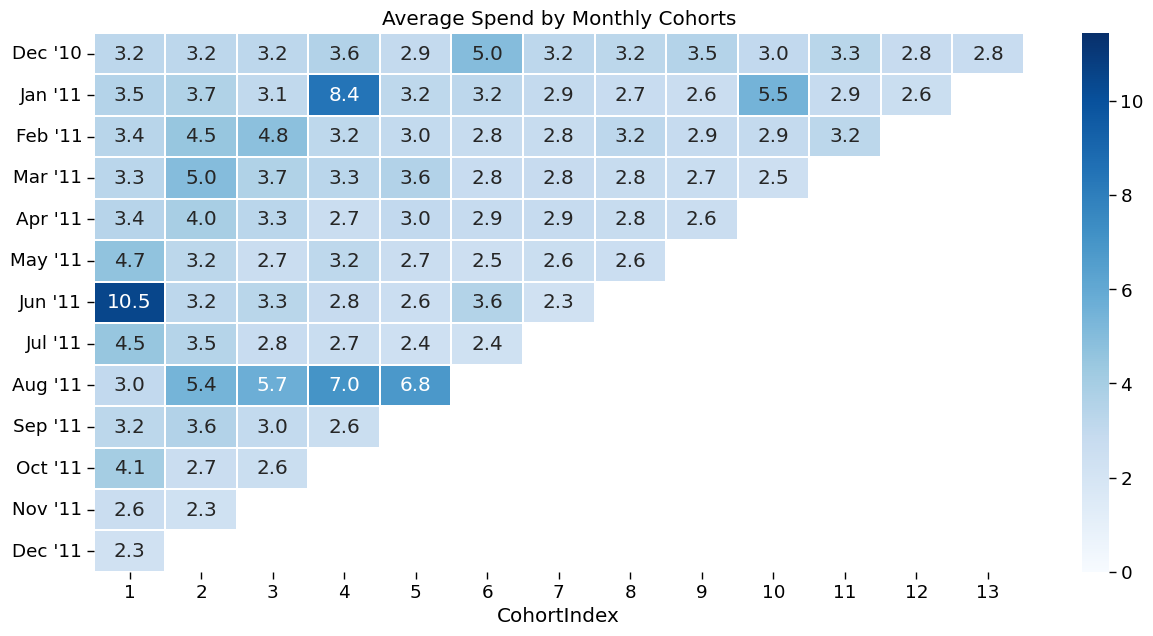

In [41]:
# Initialize plot figure
plt.figure(figsize=(15, 7))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_price,
            annot=True,
            vmin = 0.0,
#             vmax =20,
            cmap='Blues',
            vmax = list(average_price.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

#### **Interpretation**

**December '10:**
- The average price per customer in December '10 starts at 3.2 and remains relatively stable for the first few months.
- There's a noticeable increase in average price in March '11 (5.0), which could be due to specific products or promotions.
- Afterward, the average price fluctuates but generally remains above 3.0.

**January '11:**
- The average price per customer in January '11 starts at 3.5 and fluctuates over the following months.
- There's a significant spike in average price in January '11 (8.4), which might indicate high-value purchases.
- The average price then fluctuates but generally stays around 3.0.

**February '11:**
- The average price per customer in February '11 starts at 3.4 and experiences fluctuations.
- There's an increase in average price in February '11 (4.8), which might be influenced by certain factors.
- The average price remains relatively stable, with some fluctuations.

**March '11:**
- The average price per customer in March '11 starts at 3.3 and fluctuates over the following months.
- There's an increase in average price in March '11 (5.0), indicating variations in customer spending.
- The average price remains relatively stable but fluctuates.

**April '11:**
- The average price per customer in April '11 starts at 3.4 and fluctuates.
- The average price remains above 3.0 for most of the time.

**May '11:**
- The average price per customer in May '11 starts at 4.7 and decreases over the following months.
- The highest average price is in May '11 (4.7), but it declines afterward.

**June '11:**
- The average price per customer in June '11 starts at 10.5, indicating a significant increase in spending during that month.
- The average price fluctuates but generally remains above 2.0.

**July '11:**
- The average price per customer in July '11 starts at 4.5 and decreases over the following months.

**August '11:**
- The average price per customer in August '11 starts at 3.0 and increases in the following months.
- There are significant increases in average price in August '11 (5.4) and August '11 (7.0), suggesting higher-value purchases.

**September '11:**
- The average price per customer in September '11 starts at 3.2 and fluctuates over the following months.

**October '11:**
- The average price per customer in October '11 starts at 4.1 and decreases in the following months.

**November '11:**
- The average price per customer in November '11 starts at 2.6 and decreases further in December '11.

**December '11:**
- The average price per customer in December '11 is 2.3, indicating a decrease in spending during that month.


**Calculate average quantity per cohort**

Now we will calculate the average quantity metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [42]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

# Calculate the average of the Quantity column
cohort_data = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
# average_quantity.round(1)
# average_quantity.index = average_quantity.index.date

### **Monthly Average Quantity Cohorts**

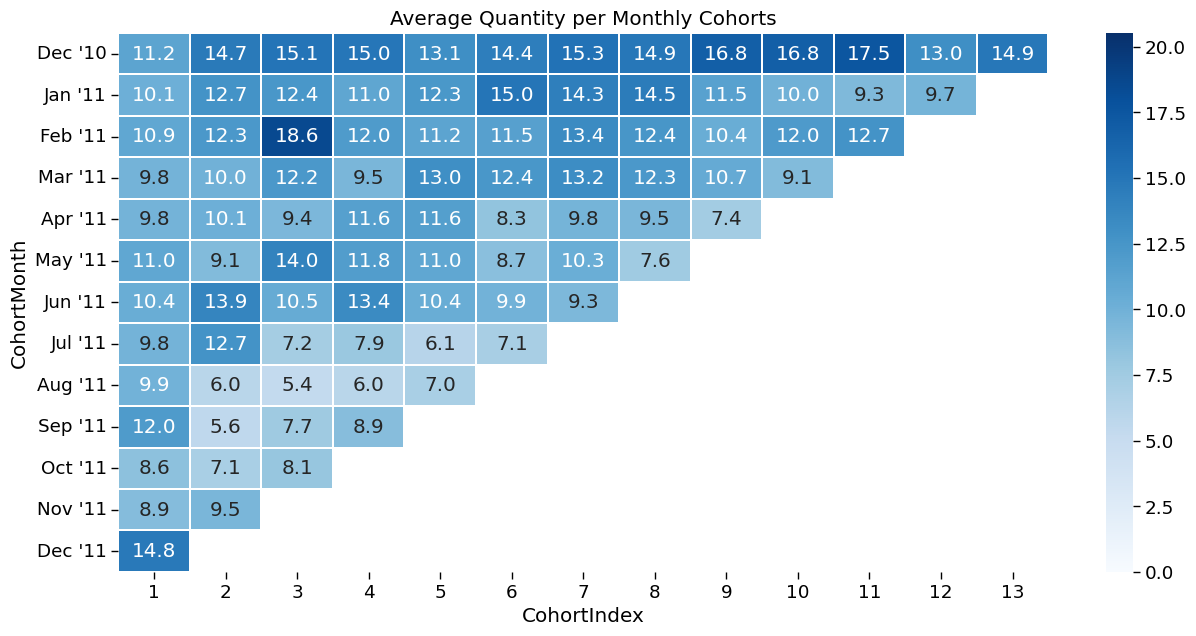

In [43]:
# Initialize plot figure
plt.figure(figsize=(15, 7))

# Add a title
plt.title('Average Quantity per Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_quantity,
            annot=True,
            vmin = 0.0,
            cmap='Blues',
            vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

#### **Interpretation**
**December '10:**
- The average quantity per customer in December '10 starts at 11.2 items and generally increases over the following months.
- There's a peak in March '11 (17.5 items), indicating that customers in this cohort purchased more items during that month.
- The average quantity remains relatively high until the end of the observation period.

**January '11:**
- The average quantity per customer in January '11 starts at 10.1 items and fluctuates over the following months.
- There's a drop in quantity in February '11, and the trend continues to fluctuate during the observation period.

**February '11:**
- The average quantity per customer in February '11 starts at 10.9 items and experiences fluctuations over the following months.
- There's a significant peak in February '11 (18.6 items), indicating a substantial increase in item quantity during that month.

**March '11:**
- The average quantity per customer in March '11 starts at 9.8 items and generally remains within a certain range over the following months.

**April '11:**
- The average quantity per customer in April '11 starts at 9.8 items and fluctuates.
- The quantity decreases in March '11 and remains relatively stable afterward.

**May '11:**
- The average quantity per customer in May '11 starts at 11.0 items and generally remains within a certain range over the following months.

**June '11:**
- The average quantity per customer in June '11 starts at 10.4 items and fluctuates over the following months.

**July '11:**
- The average quantity per customer in July '11 starts at 9.8 items and decreases over the following months.

**August '11:**
- The average quantity per customer in August '11 starts at 9.9 items and decreases further in the following months.

**September '11:**
- The average quantity per customer in September '11 starts at 12.0 items and fluctuates over the following months.

**October '11:**
- The average quantity per customer in October '11 starts at 8.6 items and fluctuates in the following months.

**November '11:**
- The average quantity per customer in November '11 starts at 8.9 items and remains relatively stable.

**December '11:**
- The average quantity per customer in December '11 is 14.8 items, indicating a significant increase in item quantity during that month.
